# Skope-Rules Demo: application to titanic survivors classification

This notebook shows a demo of skope-rules on the well-known titanic dataset. The dataset is available here: https://www.kaggle.com/c/titanic

skope-rules is appropritate in the following situations:
1. Addressing a classification problem with a binary outcome
2. Extracting decision rules which are interpretable

The notebook is structured into 5 parts:
1. Imports
2. Data preparation
3. Model training (use of ScopeRules().score_top_rules() method)
4. Interpretation of "Survival Rules" (use of SkopeRules().rules_ attribute)
5. Performance analysis (use of SkopeRules.predict_top_rules() method)

## 1. Imports

In [10]:
# Import skope-rules
from skrules import SkopeRules


# Import librairies
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from matplotlib import cm
import numpy as np
from sklearn.metrics import confusion_matrix
from IPython.display import display


# Import Titanic data
data = pd.read_csv("titanic-train.csv")

## 2. Data Preparation

In [11]:
# Remove rows with age missing
data = data.query('Age == Age')

# Create dummy for variable Sex
data['isFemale'] = (data['Sex'] == 'female') * 1

# Create dummies for variable Embarked
data = pd.concat(
    [data,
    pd.get_dummies(data.loc[:,'Embarked'], dummy_na=False, prefix='Embarked', prefix_sep='_')],
    axis=1
)

# Remove unused columns
data = data.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'Sex', 'Embarked'], axis = 1)

# Create training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Survived'], axis=1), data['Survived'], test_size=0.25, random_state=42)
feature_names = X_train.columns

print('Column names are: ' + ' '.join(feature_names.tolist())+'.')
print('Shape of training set is: ' + str(X_train.shape) + '.')

Column names are: Pclass Age SibSp Parch Fare isFemale Embarked_C Embarked_Q Embarked_S.
Shape of training set is: (535, 9).


## 3. Train models

In [12]:
# Train a gradient boosting classifier for benchmark
gradient_boost_clf = GradientBoostingClassifier(random_state=42, n_estimators=30, max_depth = 5)
gradient_boost_clf.fit(X_train, y_train)

# Train a random forest classifier for benchmark
random_forest_clf = RandomForestClassifier(random_state=42, n_estimators=30, max_depth = 5)
random_forest_clf.fit(X_train, y_train)

# Train a decision tree classifier for benchmark
decision_tree_clf = DecisionTreeClassifier(random_state=42, max_depth = 5)
decision_tree_clf.fit(X_train, y_train)

# Train a skope-rules-boosting classifier
skope_rules_clf = SkopeRules(feature_names=feature_names, random_state=42, n_estimators=30,
                               recall_min=0.05, precision_min=0.9,
                               max_samples=0.7,
                               max_depth_duplication= 4, max_depth = 5)
skope_rules_clf.fit(X_train, y_train)


# Compute prediction scores
gradient_boost_scoring = gradient_boost_clf.predict_proba(X_test)[:, 1]
random_forest_scoring = random_forest_clf.predict_proba(X_test)[:, 1]
decision_tree_scoring = decision_tree_clf.predict_proba(X_test)[:, 1]

skope_rules_scoring = skope_rules_clf.score_top_rules(X_test)

The *score_top_rules* method is used to get the skope-rules score from new data.

## 4. "Rules of Survival" extraction

In [17]:
# Get number of survival rules created
print(str(len(skope_rules_clf.rules_)) + ' rules have been built with ' +
      'SkopeRules.\n')

# Print the rules
print('The 4 most performing "Titanic survival rules" are the following one:\n')
for i_rule, rule in enumerate(skope_rules_clf.rules_[:4]):
    print(rule[0])    

11 rules have been built with SkopeRules.

The 4 most performing "Titanic survival rules" are the following one:

Age <= 43.5 and Pclass <= 2.5 and isFemale > 0.5
Age > 2.5 and Fare > 26.125 and Pclass <= 2.5 and isFemale > 0.5
Fare > 29.356249809265137 and Pclass <= 2.5 and isFemale > 0.5
Age > 2.5 and Fare <= 28.231249809265137 and Pclass <= 2.5 and isFemale > 0.5


In [14]:
def compute_y_pred_from_query(X, rule):
    score = np.zeros(X.shape[0])
    X = X.reset_index(drop=True)
    score[list(X.query(rule).index)] = 1
    return(score)

def compute_performances_from_y_pred(y_true, y_pred, index_name='default_index'):
    df = pd.DataFrame(data=
        {
            'precision':[sum(y_true * y_pred)/sum(y_pred)],
            'recall':[sum(y_true * y_pred)/sum(y_true)]
        },
        index=[index_name],
        columns=['precision', 'recall']
    )
    return(df)

def compute_train_test_query_performances(X_train, y_train, X_test, y_test, rule):
    
    y_train_pred = compute_y_pred_from_query(X_train, rule)
    y_test_pred = compute_y_pred_from_query(X_test, rule)
    
    performances = None
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_train, y_train_pred, 'train_set')],
        axis=0)
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_test, y_test_pred, 'test_set')],
        axis=0)
            
    return(performances)


print('Precision = 0.96 means that 96% of people identified by the rule are survivors.')
print('Recall = 0.12 means that the survivors identified by the rule are 12% of the total number of survivors.\n')

for i in range(4):
    print('Rule '+str(i+1)+':')
    display(compute_train_test_query_performances(X_train, y_train,
                                                  X_test, y_test,
                                                  skope_rules_clf.rules_[i][0])
           )

Precision = 0.96 means that 96% of people identified by the rule are survivors.
Recall = 0.12 means that the survivors identified by the rule are 12% of the total number of survivors.

Rule 1:


,precision,recall
train_set,0.957447,0.412844
test_set,0.937500,0.416667


Rule 2:


,precision,recall
train_set,0.986667,0.339450
test_set,0.960000,0.333333


Rule 3:


,precision,recall
train_set,0.985507,0.311927
test_set,0.950000,0.263889


Rule 4:


,precision,recall
train_set,0.913043,0.192661
test_set,0.904762,0.263889


## 5. Performance analysis

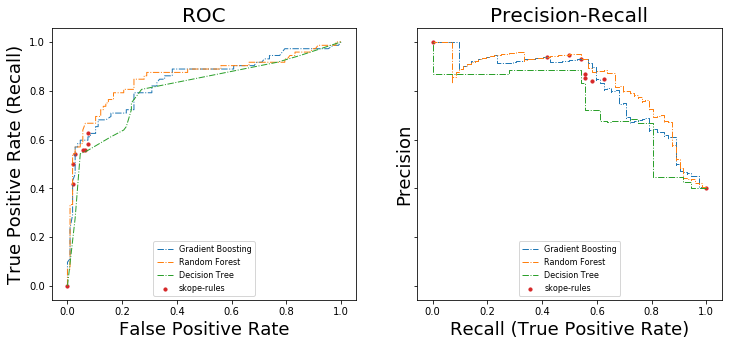

In [15]:
def plot_titanic_scores(y_true, scores_with_line=[], scores_with_points=[],
                        labels_with_line=['Gradient Boosting', 'Random Forest', 'Decision Tree'],
                        labels_with_points=['skope-rules']):
    gradient = np.linspace(0, 1, 10)
    color_list = [ cm.tab10(x) for x in gradient ]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5),
                         sharex=True, sharey=True)
    ax = axes[0]
    n_line = 0
    for i_score, score in enumerate(scores_with_line):
        n_line = n_line + 1
        fpr, tpr, _ = roc_curve(y_true, score)
        ax.plot(fpr, tpr, linestyle='-.', c=color_list[i_score], lw=1, label=labels_with_line[i_score])
    for i_score, score in enumerate(scores_with_points):
        fpr, tpr, _ = roc_curve(y_true, score)
        ax.scatter(fpr[:-1], tpr[:-1], c=color_list[n_line + i_score], s=10, label=labels_with_points[i_score])
    ax.set_title("ROC", fontsize=20)
    ax.set_xlabel('False Positive Rate', fontsize=18)
    ax.set_ylabel('True Positive Rate (Recall)', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)

    ax = axes[1]
    n_line = 0
    for i_score, score in enumerate(scores_with_line):
        n_line = n_line + 1
        precision, recall, _ = precision_recall_curve(y_true, score)
        ax.step(recall, precision, linestyle='-.', c=color_list[i_score], lw=1, where='post', label=labels_with_line[i_score])
    for i_score, score in enumerate(scores_with_points):
        precision, recall, _ = precision_recall_curve(y_true, score)
        ax.scatter(recall, precision, c=color_list[n_line + i_score], s=10, label=labels_with_points[i_score])
    ax.set_title("Precision-Recall", fontsize=20)
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=18)
    ax.set_ylabel('Precision', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)
    plt.show()
    
plot_titanic_scores(y_test,
                    scores_with_line=[gradient_boost_scoring, random_forest_scoring, decision_tree_scoring],
                    scores_with_points=[skope_rules_scoring]
                   )

On the ROC curve, each red point corresponds to a number of rules (from skope-rules) activated. For example, the lowest point is the performance point for 1 rule (the best). The second-lowest point is plot for 2 rules, etc.

On the Precision-Recall curve, the same points are plot but with different axes. Warning: the first red point on the left (0% recall, 100% precision) corresponds to 0 rule. The second point on the left is the first rule, etc.

Some conclusions can be drawn from this example:
- skope-rules performs better than a decision tree.
- skope-rules have similar performances than a random-forest/gradient boosting (in this example)
- Using 4 rules leads to a great performance (61% recall, 94% precision) (in this example).

In [16]:
n_rule_chosen = 4
y_pred = skope_rules_clf.predict_top_rules(X_test, n_rule_chosen)

print('The performances reached with '+str(n_rule_chosen)+' discovered rules are the following:')
compute_performances_from_y_pred(y_test, y_pred, 'test_set')

The performances reached with 4 discovered rules are the following:


,precision,recall
test_set,0.928571,0.541667


The *predict_top_rules(new_data, n_r)* method is used to compute predictions on *new_data* with the *n_r* first rules of skope-rules.